In [7]:
import numpy as np
import pandas as pd
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve

import scipy.stats

sys.path.append("/home/icb/sergey.vilov/workspace/MLM/mpra/utils") 

import misc

model_colors = {'DNABERT':"#D55E00",'DNABERT-3UTR':"#ffac6a", 
                'DNABERT-2':"#3F3B6C",'DNABERT2-3UTR':"#adaad0",
                '13-mer':"#CC79A7",
                'PhyloP-241way':"#ffd373",
                'PhyloP-100way':"#e69f00",
                'StateSpace':"#0072B2", 'StateSpace-SA':"#59c3ff", 
                'NTv2-250M':"#009E73", 'NTv2-250M-3UTR':"#00dea2"}

matplotlib.rcParams.update({'font.size': 16})

In [8]:
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

In [9]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/'

# Compute AUC

for each split, compute AUC and get confidence intervals via bootstrapping

In [10]:
utr_variants = pd.read_csv(data_dir + 'variants/model_scores_snp.tsv', sep='\t')

utr_variants.groupby('split').label.value_counts()

split       label
clinvar     0.0      10000
            1.0        249
eQTL-GRASP  0.0      10000
            1.0        751
eQTL-susie  0.0      10000
            1.0      10000
gnomAD      0.0      10000
            1.0      10000
Name: count, dtype: int64

In [11]:
split = 'gnomAD' # clinvar, gnomAD or eQTL

#split = sys.argv[1]
#output_name = sys.argv[2]

In [12]:
utr_variants = utr_variants[utr_variants.split==split]

In [13]:
models = ('StateSpace', 'StateSpace-SA','13-mer', 'DNABERT-2', 'DNABERT2-3UTR','PhyloP-100way', 'PhyloP-241way',
          'DNABERT', 'DNABERT-3UTR', 'NTv2-250M','NTv2-250M-3UTR')

In [14]:
utr_variants.columns

Index(['chrom', 'pos', 'source', 'label', 'ref', 'alt', 'vartype', 'seq_name',
       'seq_start', 'seq_end', 'strand', 'split', 'pos_rel',
       'PhyloP-100way-pref', 'PhyloP-241way-pref', 'StateSpace-palt',
       'StateSpace-pref', 'StateSpace-SA-palt', 'StateSpace-SA-pref',
       'DNABERT-palt', 'DNABERT-pref', 'DNABERT-3UTR-palt',
       'DNABERT-3UTR-pref', '13-mer-palt', '13-mer-pref', 'NTv2-250M-palt',
       'NTv2-250M-pref', 'NTv2-250M-3UTR-palt', 'NTv2-250M-3UTR-pref',
       'StateSpace-l1', 'StateSpace-l2', 'StateSpace-dot', 'StateSpace-cosine',
       'StateSpace-loss_ref', 'StateSpace-loss_alt', 'StateSpace-SA-l1',
       'StateSpace-SA-l2', 'StateSpace-SA-dot', 'StateSpace-SA-cosine',
       'StateSpace-SA-loss_ref', 'StateSpace-SA-loss_alt', 'DNABERT-2-l1',
       'DNABERT-2-l2', 'DNABERT-2-dot', 'DNABERT-2-cosine',
       'DNABERT-2-loss_ref', 'DNABERT-2-loss_alt', 'DNABERT2-3UTR-l1',
       'DNABERT2-3UTR-l2', 'DNABERT2-3UTR-dot', 'DNABERT2-3UTR-cosine',
       'DN

In [15]:
scores = ['pref','palt_inv','pratio','l1','l2','dot','cosine', 
          'loss_alt','loss_diff','LogisticRegression','MLP']

In [16]:
from scipy.stats import bootstrap

def bootstrap_auc(score):

    y_true = utr_variants.label[~score.isna()].values
    y_pred = score[~score.isna()].values

    auc = roc_auc_score(y_true,y_pred)

    return auc,None
    
    bs = bootstrap((y_true, y_pred),statistic=lambda x,y:roc_auc_score(x,y),
                   vectorized=False, paired=True,n_resamples=100)

    auc_err = np.diff(bs.confidence_interval)/2
    return auc, auc_err[0]
    
roc_df = []

for model_name in models:

    print(model_name)

    model_scores = []
        
    for score_name in scores:
        if score_name == 'pref':
            if f'{model_name}-pref' not in utr_variants.columns:
                model_scores.append((None,None))
                continue
            score = utr_variants[f'{model_name}-pref']
        elif score_name == 'palt_inv':
            if f'{model_name}-palt' not in utr_variants.columns:
                model_scores.append((None,None))
                continue
            score = np.log(1/utr_variants[f'{model_name}-palt'])
        elif score_name == 'pratio':
            if f'{model_name}-palt' not in utr_variants.columns:
                model_scores.append((None,None))
                continue
            score = np.log(utr_variants[f'{model_name}-pref']/utr_variants[f'{model_name}-palt'])
        elif score_name == 'loss_diff':
            if f'{model_name}-loss_alt' not in utr_variants.columns:
                model_scores.append((None,None))
                continue
            score = utr_variants[f'{model_name}-loss_alt']-utr_variants[f'{model_name}-loss_ref']
        else:
            if f'{model_name}-{score_name}' not in utr_variants.columns:
                model_scores.append((None,None))
                continue
            score = utr_variants[f'{model_name}-{score_name}']
        print(score_name)
        bootstrap_est = bootstrap_auc(score)
        model_scores.append(bootstrap_est)
        
    roc_df.append((model_name, *model_scores))

StateSpace
pref
palt_inv
pratio
l1
l2
dot
cosine
loss_alt
loss_diff
LogisticRegression
MLP
StateSpace-SA
pref
palt_inv
pratio
l1
l2
dot
cosine
loss_alt
loss_diff
LogisticRegression
MLP
13-mer
pref
palt_inv
pratio
DNABERT-2
l1
l2
dot
cosine
loss_alt
loss_diff
LogisticRegression
MLP
DNABERT2-3UTR
l1
l2
dot
cosine
loss_alt
loss_diff
LogisticRegression
MLP
PhyloP-100way
pref
PhyloP-241way
pref
DNABERT
pref
palt_inv
pratio
l1
l2
dot
cosine
loss_alt
loss_diff
LogisticRegression
MLP
DNABERT-3UTR
pref
palt_inv
pratio
l1
l2
dot
cosine
loss_alt
loss_diff
LogisticRegression
MLP
NTv2-250M
pref
palt_inv
pratio
l1
l2
dot
cosine
loss_alt
loss_diff
LogisticRegression
MLP
NTv2-250M-3UTR
pref
palt_inv
pratio
l1
l2
dot
cosine
loss_alt
loss_diff
LogisticRegression
MLP


In [17]:
roc_df = pd.DataFrame(roc_df,columns=['model'] + scores)

In [18]:
#roc_df.to_csv(data_dir + 'perbase_pred/auc_nomask.csv', index=False)

# Make auc table

In [19]:
#models = ('DNABERT', 'DNABERT-3UTR', 'DNABERT2', 'DNABERT2-3UTR', 'NTv2-250M','NTv2-250M-3UTR',
#         'StateSpace', 'StateSpace-SA','13-mer', 'PhyloP-100way', 'PhyloP-241way')

models = ('DNABERT', 'DNABERT-3UTR', 'DNABERT-2', 'DNABERT2-3UTR', 'NTv2-250M','NTv2-250M-3UTR',
         'StateSpace', 'StateSpace-SA', 'PhyloP-100way', 'PhyloP-241way')

subsets = ('clinvar','gnomAD','eQTL-susie','eQTL-GRASP')

In [20]:
roc_df = []

for split in subsets:
    df = pd.read_csv(data_dir + f'variants/auc/{split}.tsv', sep='\t')
    df['split']=split
    df = df.set_index('model').loc(axis=0)[models]
    df.reset_index(inplace=True)
    roc_df.append(df)
    
roc_df = pd.concat(roc_df)

roc_df = roc_df.map(lambda x: '(0,0)' if x=='(None, None)' else x)

In [21]:
roc_df.set_index(['split','model'], inplace=True)
roc_df = roc_df.map(lambda x: (float(x.split(',')[0].lstrip('(')),
                               float(x.split(',')[1].rstrip(')'))))

roc_df = roc_df.applymap(lambda x:(1-x[0],x[1]) if x[0]<0.5 and x[0]>0 else x)

/tmp/ipykernel_1255635/2168254134.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  roc_df = roc_df.applymap(lambda x:(1-x[0],x[1]) if x[0]<0.5 and x[0]>0 else x)


In [22]:
zero_shot_df = roc_df[['pref', 'palt_inv', 'pratio', 'l1', 'l2', 'dot', 'cosine', 'loss_alt',
       'loss_diff']].reset_index()

zero_shot_df = zero_shot_df[~zero_shot_df.model.str.contains('PhyloP')]

In [23]:
zero_shot_df = zero_shot_df.groupby('split', sort=False).apply(
    lambda x:x.set_index('model').T.drop('split'))

In [24]:
def is_overlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))>0
    
best_models = {}
    
for split in subsets:
        
    split_data = zero_shot_df.loc[split]
        
    best_auc, best_auc_err =  sorted(split_data.values.flatten())[-1]
    
    best_models[split] = []
    
    for model in split_data.columns:
        for score in split_data.index:
            auc, auc_err = split_data.loc[score,model]
                #print (split,model,score,auc,auc_err,'T')
            if auc-auc_err>0.5 and is_overlap((best_auc-best_auc_err,best_auc+best_auc_err),(auc-auc_err,auc+auc_err)):
                #print (split,model,score,auc,auc_err)
                best_models[split].append((model,score))

def get_color(x):
    
    auc = x[0]
    auc = max(auc-0.5,0)
    auc = min(auc,0.8)/0.8
    cmap = matplotlib.colormaps['Oranges']
    rgb_code=(np.array(cmap(auc))*255).astype(int)
    hex_code='#{:02x}{:02x}{:02x}'.format(*rgb_code[:3])
    
    return hex_code
    
def highlight_ns(x,best_models):
    #make the best model and models with insignificant difference with the best model bold
    split, score = x.name
    return [f'font-weight: bold;background-color: {get_color(zero_shot_df.loc[(split,score),model])}' 
            if (model,score) in best_models[split] else f'background-color: {get_color(zero_shot_df.loc[(split,score),model])}'
                for model in x.index]

In [25]:
zero_shot_df_ = zero_shot_df.map(lambda x: f'{x[0]:.3f}±{x[1]:.3f}' if x!=(0,0) else '-')

#df = df.rename(columns={'ref_auc':'$P_{ref}$','inv_alt_auc':'$P^{-1}_{alt}$','ratio_auc':'$P_{ref}/P_{alt}$'})

In [26]:
styler=zero_shot_df_.style.apply(lambda x: highlight_ns(x, best_models),axis=1)
styler

In [27]:
#styler.to_excel(data_dir + 'variants/auc/zero_shot.xlsx')
#roc_df.to_csv(data_dir + 'variants/auc/auc.tsv',sep='\t')

data_dir + 'variants/auc/zero_shot.xlsx'

'/lustre/groups/epigenereg01/workspace/projects/vale/mlm/variants/auc/zero_shot.xlsx'

In [28]:
models_df = roc_df[['pref','MLP']].apply(lambda x:x.sort_values().iloc[-1],axis=1).rename('auc').reset_index()
models_df = models_df.pivot(columns='split',index='model',values='auc').loc[models,subsets]

best_models = models_df.apply(misc.get_best_models).to_dict()

models_df = models_df.map(lambda x: f'{x[0]:.3f}±{x[1]:.3f}')

models_df.iloc[:,:3].style.apply(lambda x: misc.highlight_ns(x, best_models))

split,clinvar,gnomAD,eQTL-susie
model,,,
DNABERT,0.957±0.019,0.593±0.011,0.574±0.011
DNABERT-3UTR,0.953±0.021,0.606±0.011,0.585±0.011
DNABERT-2,0.963±0.023,0.594±0.010,0.683±0.010
DNABERT2-3UTR,0.952±0.027,0.551±0.012,0.629±0.011
NTv2-250M,0.942±0.024,0.560±0.011,0.592±0.011
NTv2-250M-3UTR,0.915±0.028,0.559±0.011,0.598±0.011
StateSpace,0.958±0.021,0.585±0.011,0.626±0.010
StateSpace-SA,0.954±0.024,0.585±0.011,0.625±0.010
PhyloP-100way,0.915±0.022,0.623±0.008,0.519±0.008


In [29]:
def get_best_score(x):
    x = x.sort_values()
    return pd.Series({'score_name':x.index[-1],'auc':x.iloc[-1][0]})

best_score_df = roc_df[['pref','MLP']].apply(get_best_score,axis=1)

best_score_list = best_score_df.reset_index().sort_values(
    by=['split','auc'],ascending=False).set_index(['split','model']).auc

In [30]:
utr_variants = pd.read_csv(data_dir + 'variants/model_scores_snp.tsv', sep='\t')

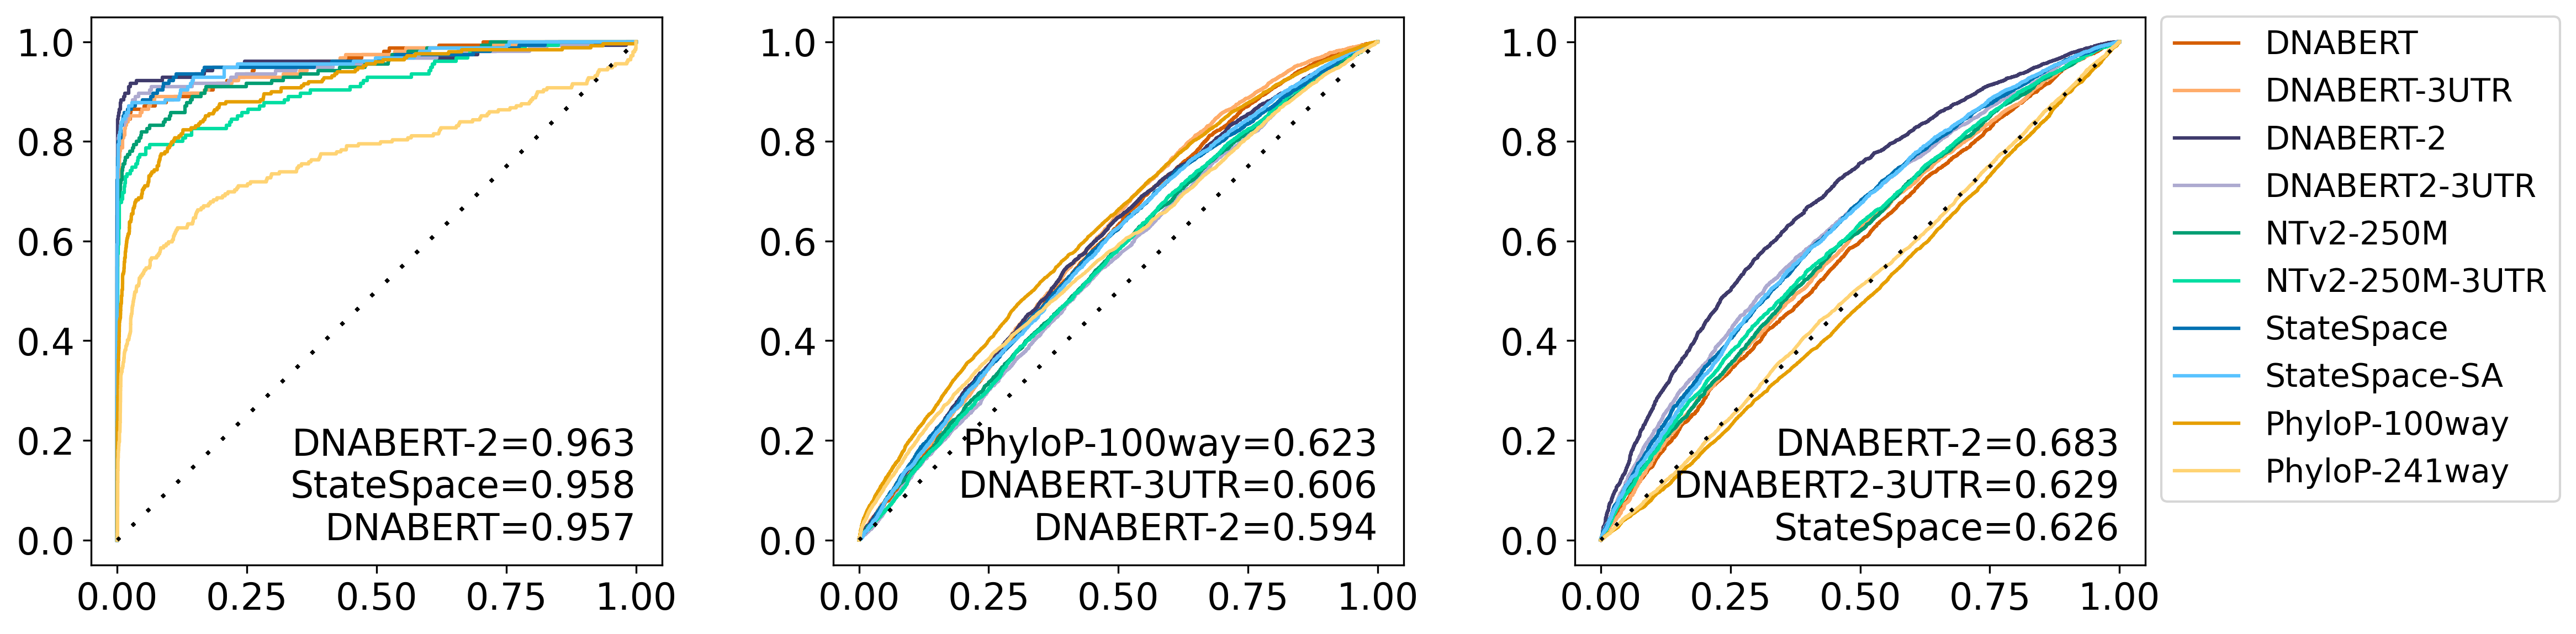

In [32]:
fig, axes = plt.subplots(1,3, figsize=(16,4.3),dpi=300)

x = np.arange(0,1,0.01)

ax_idx = 0
for ax,split in zip(axes,('clinvar','gnomAD','eQTL-susie')):
    ax_idx+=1
    text=[]
    for model_idx, (model,score_name) in enumerate(best_score_df.loc[split].score_name.items()):
        df = utr_variants[(utr_variants.split==split)][['label',model+'-'+score_name]].rename(columns={'label':'y_true',model+'-'+score_name:'y_pred'})
        df = df[~df.y_pred.isna()]
        fpr, tpr, _ = roc_curve(df.y_true,df.y_pred)
        ax.plot(fpr,tpr,color=model_colors[model],label=model)
        ax.plot(x,x, linestyle=(0,(1,5)), color='k')
    for model,auc in best_score_list.loc[split].iloc[:3].items():
        text.append(f'{model}={auc:.3f}')
    ax.text(1,0,'\n'.join(text),horizontalalignment='right')
    if ax_idx==3:
        ax.legend(bbox_to_anchor=(1, 1.03),ncol=1, fontsize=14)

plt.subplots_adjust(wspace=0.3)